In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom
import matplotlib.image as mpimg
from tqdm import tqdm_notebook
import cv2
import os
import re
from scipy import ndimage
from skimage import morphology
import PIL

In [35]:
base_url = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/'

In [21]:
TRAIN_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_train'
TEST_DIR = '/home/ubuntu/kaggle/rsna-intracranial-hemorrhage-detection/stage_2_test'

In [3]:
! ls {TRAIN_DIR} | wc -l

752803


In [4]:
! ls {TEST_DIR} | wc -l

121232


In [5]:
! ls {TRAIN_DIR} | head -n 5

ID_000012eaf.dcm
ID_000039fa0.dcm
ID_00005679d.dcm
ID_00008ce3c.dcm
ID_0000950d7.dcm
ls: write error: Broken pipe


## Prepare the labels & metadata
The metadata was extracted beforehand using pydicom. This takes a while so I saved the results in these parquet files so they don't need to be generated each time.

In [45]:
train_df = pd.read_csv(f'{base_url}/stage_2_train.csv').drop_duplicates()
train_df['ImageID'] = train_df['ID'].str.slice(stop=12)
train_df['Diagnosis'] = train_df['ID'].str.slice(start=13)
train_labels = train_df.pivot(index="ImageID", columns="Diagnosis", values="Label")
train_labels.head()

Diagnosis,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
ImageID,,,,,,
ID_000012eaf,0,0,0,0,0,0
ID_000039fa0,0,0,0,0,0,0
ID_00005679d,0,0,0,0,0,0
ID_00008ce3c,0,0,0,0,0,0
ID_0000950d7,0,0,0,0,0,0


In [30]:
def get_metadata(image_dir):

    labels = [
        'BitsAllocated', 'BitsStored', 'Columns', 'HighBit', 
        'ImageOrientationPatient_0', 'ImageOrientationPatient_1', 'ImageOrientationPatient_2',
        'ImageOrientationPatient_3', 'ImageOrientationPatient_4', 'ImageOrientationPatient_5',
        'ImagePositionPatient_0', 'ImagePositionPatient_1', 'ImagePositionPatient_2',
        'Modality', 'PatientID', 'PhotometricInterpretation', 'PixelRepresentation',
        'PixelSpacing_0', 'PixelSpacing_1', 'RescaleIntercept', 'RescaleSlope', 'Rows', 'SOPInstanceUID',
        'SamplesPerPixel', 'SeriesInstanceUID', 'StudyID', 'StudyInstanceUID', 
        'WindowCenter', 'WindowWidth', 'Image',
    ]

    data = {l: [] for l in labels}

    for image in tqdm_notebook(os.listdir(image_dir)):
        data["Image"].append(image[:-4])

        ds = pydicom.dcmread(os.path.join(image_dir, image))

        for metadata in ds.dir():
            if metadata != "PixelData":
                metadata_values = getattr(ds, metadata)
                if type(metadata_values) == pydicom.multival.MultiValue and metadata not in ["WindowCenter", "WindowWidth"]:
                    for i, v in enumerate(metadata_values):
                        data[f"{metadata}_{i}"].append(v)
                else:
                    if type(metadata_values) == pydicom.multival.MultiValue and metadata in ["WindowCenter", "WindowWidth"]:
                        data[metadata].append(metadata_values[0])
                    else:
                        data[metadata].append(metadata_values)

    return pd.DataFrame(data).set_index("Image")

In [ ]:
# Generate metadata dataframes
train_metadata = get_metadata(os.path.join(base_url, "stage_2_train"))
test_metadata = get_metadata(os.path.join(base_url, "stage_2_test"))

train_metadata.to_parquet(f'{base_url}/train_metadata.parquet.gzip', compression='gzip')
test_metadata.to_parquet(f'{base_url}/test_metadata.parquet.gzip', compression='gzip')

In [42]:
train_metadata.T

Image,ID_d45673798,ID_74cfe18f9,ID_d7e2f42ee,ID_e6c5352ea,ID_688b50fa0,ID_ef18adb45,ID_94544b40d,ID_2a019f628,ID_9bffe2b90,ID_7ccdde5eb,...,ID_72b376d48,ID_bf64dc996,ID_7355aedc3,ID_89ce8ad00,ID_3a25fd051,ID_529052515,ID_f540aa7fb,ID_5f0c548d7,ID_2bc16380c,ID_c161feeeb
BitsAllocated,16,16,16,16,16,16,16,16,16,16,...,16,16,16,16,16,16,16,16,16,16
BitsStored,16,16,12,12,16,12,16,16,12,16,...,16,16,12,12,12,16,16,16,12,16
Columns,512,512,512,512,512,512,512,512,512,512,...,512,512,512,512,512,512,512,512,512,512
HighBit,15,15,11,11,15,11,15,15,11,15,...,15,15,11,11,11,15,15,15,11,15
ImageOrientationPatient_0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
ImageOrientationPatient_1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ImageOrientationPatient_2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ImageOrientationPatient_3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ImageOrientationPatient_4,0.945519,1,1,1,0.993572,1,0.927184,0.906308,0.981627,1,...,1,0.927184,1,1,1,0.927184,0.992546,0.992546,1,0.95882
ImageOrientationPatient_5,-0.325568,0,0,0,-0.113203,0,-0.374607,-0.422618,-0.190809,0,...,0,-0.374607,0,0,0,-0.374607,-0.121869,-0.121869,0,-0.284015


In [47]:
train_metadata = pd.read_parquet(f'{base_url}/train_metadata.parquet.gzip')
test_metadata = pd.read_parquet(f'{base_url}/test_metadata.parquet.gzip')

train_metadata["Dataset"] = "train"
test_metadata["Dataset"] = "test"

train_metadata = train_metadata.join(train_labels)

metadata = pd.concat([train_metadata, test_metadata], sort=True)
metadata.sort_values(by="ImagePositionPatient_2", inplace=True, ascending=False)
metadata.head()

,BitsAllocated,BitsStored,Columns,Dataset,HighBit,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,...,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
Image,,,,,,,,,,,,,,,,,,,,,
ID_24250ffbc,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_6e8c8d650,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_ac042708d,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_d1e2a17a9,16,12,512,train,11,1.0,0.0,0.0,0.0,0.927184,...,,ID_a5fb903898,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_e1a1b45a5,16,12,512,train,11,1.0,0.0,0.0,0.0,0.920505,...,,ID_6222a3935b,40.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
metadata["StudyInstanceUID"].nunique()

25262

In [50]:
metadata["SeriesInstanceUID"].nunique()

25262

In [49]:
metadata["PatientID"].nunique()

22456

## Group the unique studies

In [83]:
studies = metadata.groupby("StudyInstanceUID")
studies_list = list(studies)



In [84]:
study_name, study_df = studies_list[2000]
study_df.head()

,BitsAllocated,BitsStored,Columns,Dataset,HighBit,ImageOrientationPatient_0,ImageOrientationPatient_1,ImageOrientationPatient_2,ImageOrientationPatient_3,ImageOrientationPatient_4,...,StudyID,StudyInstanceUID,WindowCenter,WindowWidth,any,epidural,intraparenchymal,intraventricular,subarachnoid,subdural
Image,,,,,,,,,,,,,,,,,,,,,
ID_865122213,16,16,512,train,15,1.0,0.0,0.0,0.0,0.927184,...,,ID_13eda5126c,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_51a161001,16,16,512,train,15,1.0,0.0,0.0,0.0,0.927184,...,,ID_13eda5126c,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_9f9e9b705,16,16,512,train,15,1.0,0.0,0.0,0.0,0.927184,...,,ID_13eda5126c,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_d985de5b7,16,16,512,train,15,1.0,0.0,0.0,0.0,0.927184,...,,ID_13eda5126c,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0
ID_2837d7a95,16,16,512,train,15,1.0,0.0,0.0,0.0,0.927184,...,,ID_13eda5126c,30.0,80.0,0.0,0.0,0.0,0.0,0.0,0.0


In [85]:
studies.size().describe()

count    25262.000000
mean        34.598805
std          5.080465
min         20.000000
25%         32.000000
50%         33.000000
75%         37.000000
max         60.000000
dtype: float64

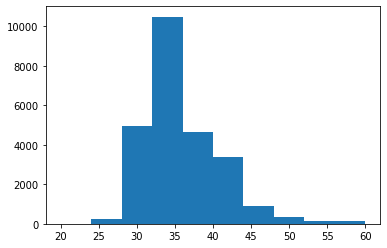

In [65]:
plt.hist(studies.size());

# Create a 3D volume for a single study
We'll use the first study in the grouped studies which is comprised of 40 individial axial DICOM images

In [66]:
def window_img(dcm, width=None, level=None, norm=True):
    pixels = dcm.pixel_array * dcm.RescaleSlope + dcm.RescaleIntercept
    
    # Pad non-square images
    if pixels.shape[0] != pixels.shape[1]:
        (a,b) = pixels.shape
        if a > b:
            padding = ((0, 0), ((a-b) // 2, (a-b) // 2))
        else:
            padding = (((b-a) // 2, (b-a) // 2), (0, 0))
        pixels = np.pad(pixels, padding, mode='constant', constant_values=0)
            
    if not width:
        width = dcm.WindowWidth
        if type(width) != pydicom.valuerep.DSfloat:
            width = width[0]
    if not level:
        level = dcm.WindowCenter
        if type(level) != pydicom.valuerep.DSfloat:
            level = level[0]
    lower = level - (width / 2)
    upper = level + (width / 2)
    img = np.clip(pixels, lower, upper)
    
    if norm:
        return (img - lower) / (upper - lower)
    else:
        return img

In [86]:
volume, labels = [], []
for index, row in study_df.iterrows():
    if row["Dataset"] == "train":
        dcm = pydicom.dcmread(os.path.join(base_url, "stage_2_train", index+".dcm"))
    else:
        dcm = pydicom.dcmread(os.path.join(base_url, "stage_2_test", index+".dcm"))
        
    img = window_img(dcm)
    label = row[["any", "epidural", "intraparenchymal", "intraventricular", "subarachnoid", "subdural"]]
    volume.append(img)
    labels.append(label)
    
volume = np.array(volume)
labels = np.array(labels)

In [87]:
volume.shape, labels.shape

((32, 512, 512), (32, 6))

> The provided DICOM images are axial slices. Let's use our new 3D volume to create sagittal and coronal slices

> * Red line - axial plane
> * Green line - sagittal plane
> * Blue line - coronal plane

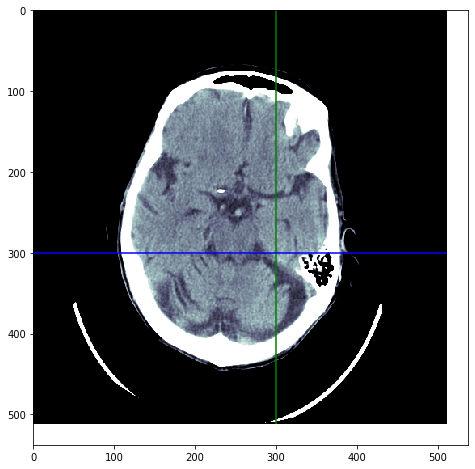

In [88]:
# Axial
plt.figure(figsize=(8, 8))
plt.imshow(volume[20, :, :], cmap=plt.cm.bone)
plt.vlines(300, 0, 512, colors='g')
plt.hlines(300, 0, 512, colors='b');

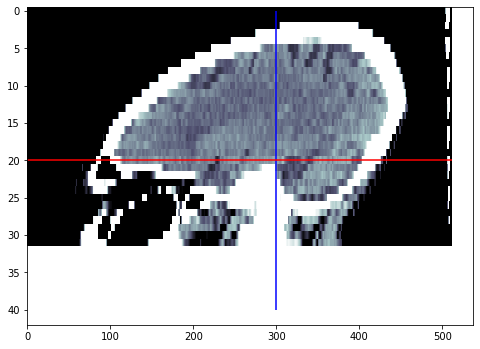

In [89]:
# Sagittal
plt.figure(figsize=(8, 8))
plt.imshow(volume[:, :, 300], aspect=9, cmap=plt.cm.bone)
plt.vlines(300, 0, 40, colors='b')
plt.hlines(20, 0, 512, colors='r');

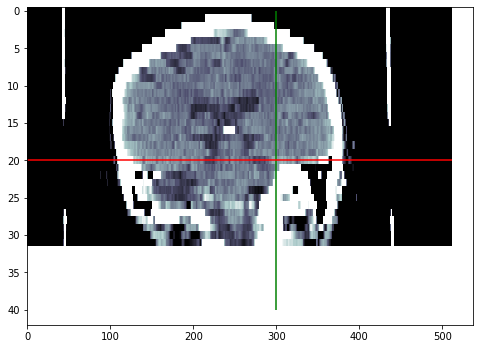

In [90]:
# Coronal
plt.figure(figsize=(8, 8))
plt.imshow(volume[:, 300, :], aspect=9, cmap=plt.cm.bone)
plt.vlines(300, 0, 40, colors='g')
plt.hlines(20, 0, 512, colors='r');